In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/mrl.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [3]:
len(os.listdir('/tmp/mrl/train/open_eye'))

32214

In [40]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.preprocessing import  image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPool2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
batchsize=8

In [7]:
train_datagen= ImageDataGenerator(rescale=1./255, rotation_range=0.2,shear_range=0.2,
    zoom_range=0.2,width_shift_range=0.2,
    height_shift_range=0.2, validation_split=0.2)

train_data= train_datagen.flow_from_directory(r'/tmp/mrl/train',
                                target_size=(80,80),batch_size=batchsize,class_mode='categorical',subset='training' )

validation_data= train_datagen.flow_from_directory(r'/tmp/mrl/train',
                                target_size=(80,80),batch_size=batchsize,class_mode='categorical', subset='validation')

Found 50940 images belonging to 2 classes.
Found 12733 images belonging to 2 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(r'/tmp/mrl/test',
                                target_size=(80,80),batch_size=batchsize,class_mode='categorical')

Found 21225 images belonging to 2 classes.


In [9]:
# Creating a Custom CNN Model:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(2, activation='softmax'))

In [10]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 39, 39, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 18, 18, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

In [12]:
checkpoint = ModelCheckpoint(r'/tmp/mrl/cnn.h5',
                            monitor='val_loss',save_best_only=True,verbose=3)

#earlystop = EarlyStopping(monitor = 'val_loss', patience=7, verbose= 3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3, )

#callbacks=[checkpoint,earlystop,learning_rate]
callbacks=[checkpoint,learning_rate]

In [13]:
model_cnn.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

model_fit_cnn = model_cnn.fit_generator(
    train_data,
    steps_per_epoch=train_data.samples // batchsize,
    validation_data=validation_data,
    validation_steps=validation_data.samples // batchsize,
    callbacks=callbacks,
    epochs=5
)

Epoch 1/5
6366/6367 [============================>.] - ETA: 0s - loss: 0.3591 - accuracy: 0.8364
Epoch 1: val_loss improved from inf to 0.54268, saving model to /tmp/mrl/cnn.h5
6367/6367 [==============================] - 195s 30ms/step - loss: 0.3591 - accuracy: 0.8364 - val_loss: 0.5427 - val_accuracy: 0.8174 - lr: 0.0010
Epoch 2/5
6367/6367 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.9328
Epoch 2: val_loss improved from 0.54268 to 0.34173, saving model to /tmp/mrl/cnn.h5
6367/6367 [==============================] - 187s 29ms/step - loss: 0.1811 - accuracy: 0.9328 - val_loss: 0.3417 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 3/5
6366/6367 [============================>.] - ETA: 0s - loss: 0.1414 - accuracy: 0.9502
Epoch 3: val_loss improved from 0.34173 to 0.26410, saving model to /tmp/mrl/cnn.h5
6367/6367 [==============================] - 187s 29ms/step - loss: 0.1414 - accuracy: 0.9502 - val_loss: 0.2641 - val_accuracy: 0.9049 - lr: 0.0010
Epoch 4/5
6366

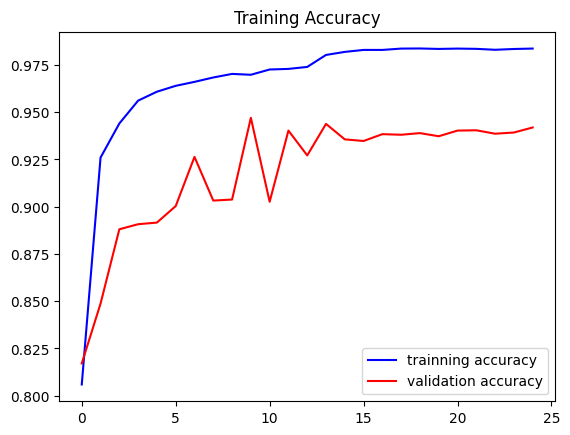

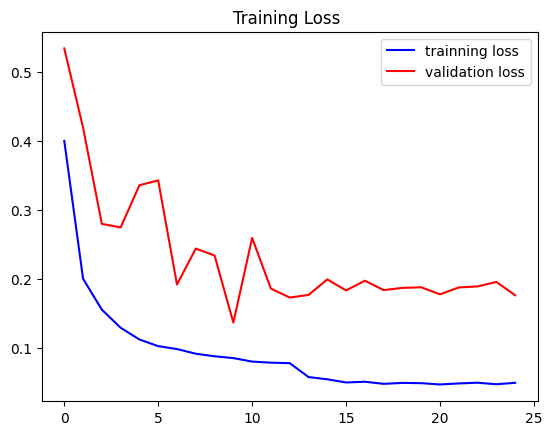

<Figure size 640x480 with 0 Axes>

In [ ]:
accuracy = model_fit_cnn.history['accuracy']
val_accuracy = model_fit_cnn.history['val_accuracy']
loss = model_fit_cnn.history['loss']
val_loss = model_fit_cnn.history['val_loss']
epochs = range(len(accuracy))



plt.title("Training Accuracy")
plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()
plt.savefig("Accuracy.jpg")


plt.title("Training Loss ")
plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()
plt.savefig("Loss.jpg")

1/1 [==============================] - 0s 27ms/step
[[1.477262e-07 9.999999e-01]]


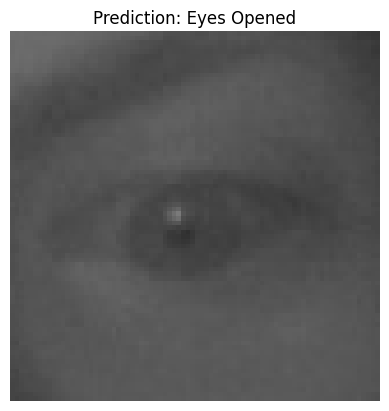

1/1 [==============================] - 0s 24ms/step
[[9.9999964e-01 3.1399020e-07]]


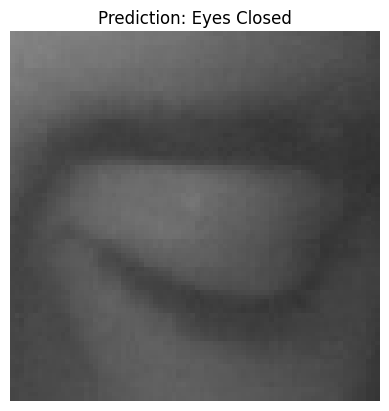

In [44]:
# Load a random image for prediction
image_paths = [r'/tmp/mrl/s0002_01103_0_0_1_0_0_01.png', r'/tmp/mrl/s0012_00013_0_0_0_0_0_01.png' ]
for img_path in image_paths:

  img = image.load_img(img_path, target_size=(80, 80))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0  # Normalize the image

  # Make predictions
  predictions = model_cnn.predict(img_array)
  print(predictions)

  plt.imshow(img)
  plt.axis('off')
  plt.title('Prediction: Eyes Closed' if predictions[0][0] > predictions[0][1] else 'Prediction: Eyes Opened')
  plt.show()

